In [1]:
# check available gpus
# !nvidia-smi

In [2]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [3]:
from external.loss_utils import PerceptualTextureLoss, tv_loss 
from modules.basic_utils import read_image, lazy_plot
from modules.utils import get_texture_map

In [4]:
# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image

verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [5]:
image_resolution = 256#128#256 # 512

In [6]:
renderer = Renderer(image_resolution=image_resolution,device=device,blur_radius=0.0)
renderer.load_inputs(verts_T_paths,tm_paths = tm_paths,
                     euler_list = euler_list)
images = renderer.render()
renderer.texture_map.shape # [1,1024,1024,3]
# renderer.show()

torch.Size([1, 1024, 1024, 3])

In [26]:

# for experiment without texture flow
# tgt = remove_background(image_path,seg_mask_path)
# tgt = squared_image(tgt)
# tgt = torch.from_numpy(tgt).permute(2,0,1).float().unsqueeze(0).to(device)
# from skimage.transform import resize
# tgt = resize(tgt,(image_resolution,image_resolution))

# ------------------------------
# for experiment with texture flow
tgt = read_image(image_path)[None,...]
 # ndarray (1,128, 64, 3)

texture_loss = PerceptualTextureLoss()

# create texture flow 
texture_flow = torch.rand(1, 1024, 1024, 2)
texture_flow.requires_grad = True



Setting up Perceptual loss..


/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [28]:
tm = get_texture_map(texture_flow,tgt)

/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


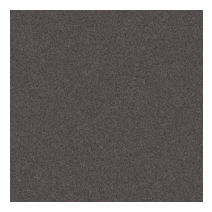

In [30]:
lazy_plot(tm)

In [10]:
# training loop to learn texture and T from image
params = [ renderer.texture_map] #renderer.verts,renderer.T
optim = torch.optim.Adam(params,lr=0.1)


for i in range(10):
    optim.zero_grad()
    images = renderer.render()

    images = images.permute(0,3,1,2)[:,:3,:,:].float().to(device)

    # resize both to 256,256
    
    
    perceptual_loss = texture_loss(images,tgt)
    loss = perceptual_loss # + 0.5 * tv_loss(renderer.texture_map)
    print('i :' , i,'loss:',loss.item())
    



    # diff = images[0,...,:3] - torch.from_numpy(tgt).to(device)
    # loss = torch.sum(diff**2) + 0.5 * tv_loss(renderer.texture_map)
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%300 == 0:
        plt.figure(figsize=(3,3))
        plt.imshow(images[0,...,:3].cpu().detach().numpy().clip(0,1))
        plt.axis('off')
        plt.show()
        
        # print(renderer.T)
        # print(renderer.texture_map)
        # print(renderer.verts)
        print('loss:',loss.item())
 


i : 0 loss: 1.5571731328964233


loss: 1.5571731328964233
i : 1 loss: 1.5519890785217285
i : 2 loss: 1.5468926429748535
i : 3 loss: 1.5419141054153442
i : 4 loss: 1.5370244979858398
i : 5 loss: 1.5322387218475342
i : 6 loss: 1.5275626182556152
i : 7 loss: 1.5229586362838745
i : 8 loss: 1.5184047222137451
i : 9 loss: 1.5139412879943848


In [ ]:
# save texture
plt.imsave("data/exp/changed_texture_perceptual.jpg",texture.clip(0,1))